In [1]:
#
# Observe Convolutional Neural Network MNIST
#
# @author becxer
# @email becxer87@gmail.com
# @reference https://github.com/sjchoi86/Tensorflow-101
#

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline  

print ("packages are loaded")

packages are loaded


In [2]:
# Get MNIST data set from tensorflow
from tensorflow.examples.tutorials.mnist import input_data
mnist_set = input_data.read_data_sets('images/MNIST/', one_hot = True)

train_img = mnist_set.train.images
train_label = mnist_set.train.labels
test_img = mnist_set.test.images
test_label = mnist_set.test.labels

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [3]:
# Options for training
learning_rate = 0.01
training_epochs = 50
batch_size = 100
display_step = 10

# Options for Convolution
x_conv_shape =  [-1,28,28,1] # because MNIST data is oneline

n_conv_shapes = [[3,3,1,64]]
n_conv_strides = [[1,1,1,1]]
n_maxp_shapes = [[1,2,2,1]]
n_maxp_strides = [[1,2,2,1]]

# Options for Dense layer
x_dense_size = 14 * 14 * 64
n_dense = [100]
w_dev = 0.1

In [4]:
# Build Graph of Convolution Neural Network

# Define placeholder & Variables
x = tf.placeholder("float", [None, train_img.shape[1]])
y = tf.placeholder("float", [None, train_label.shape[1]])

def one_cnn_layer(_x, _weight_C, _stride_C, _bias_C, _shape_MP, _stride_MP):
    _conv1 = tf.nn.conv2d(_x, _weight_C, strides=_stride_C, padding='SAME')
    _conv2 = tf.nn.bias_add(_conv1, _bias_C)
    _conv3 = tf.nn.relu(_conv2)
    _pool = tf.nn.max_pool(_conv3, ksize=_shape_MP, strides=_stride_MP, padding='SAME')
    return {'conv1':_conv1, 'conv2':_conv2, 'conv3':_conv3, 'pool':_pool, 'out':_pool}

def one_dense_layer(_x, _W, _b):
    return tf.nn.sigmoid(tf.add(tf.matmul(_x, _W),_b))

WS = {}
BS = {}
Layers = []

last_input_layer = tf.reshape(x, shape = x_conv_shape)
for idx in range(len(n_conv_shapes)):
    _weight_C = tf.Variable(tf.random_normal(n_conv_shapes[idx], stddev=w_dev))
    _stride_C = n_conv_strides[idx]
    _bias_C = tf.Variable(tf.random_normal([n_conv_shapes[idx][-1]], stddev=w_dev))
    _shape_MP = n_maxp_shapes[idx]
    _stride_MP = n_maxp_strides[idx]
    layer = one_cnn_layer(last_input_layer, _weight_C, _stride_C, _bias_C, _shape_MP, _stride_MP)
    last_input_layer = layer['out']
    WS['wc_' + str(idx)] = _weight_C
    BS['bc_' + str(idx)] = _bias_C
    Layers.append(layer)

last_input_layer_size = x_dense_size
last_input_layer = tf.reshape(last_input_layer, [-1, x_dense_size])

for idx, hl_size in enumerate(n_dense):
    _W = tf.Variable(tf.random_normal([last_input_layer_size, hl_size], stddev=w_dev))
    _b = tf.Variable(tf.random_normal([hl_size])) 
    last_input_layer = one_dense_layer(last_input_layer, _W, _b)
    last_input_layer_size = hl_size
    WS['wd_' + str(idx)] = _W
    BS['bd_' + str(idx)] = _b
    Layers.append(layer)

WS['out'] = tf.Variable(tf.random_normal([last_input_layer_size, train_label.shape[1]], stddev=w_dev))
BS['out'] = tf.Variable(tf.random_normal([train_label.shape[1]], stddev=w_dev))

# Define operators
out = one_dense_layer(last_input_layer, WS['out'], BS['out'])

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(out, y))
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

pred = tf.argmax(out, 1)
accr = tf.reduce_mean(tf.cast(tf.equal(pred, tf.argmax(y, 1)),"float"))

init = tf.initialize_all_variables()
print ("Graph build")

Graph build


In [5]:
# Options for load model
load_dir = "models/"
load_keyword = "cnn_mnist.epoch-"
load_epoch = "49"

# Load saver
saver = tf.train.Saver()

# Restore graph session
sess = tf.Session()

ckpt = tf.train.get_checkpoint_state(load_dir)
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, load_dir + load_keyword + load_epoch)

In [6]:
# Test Load model
avg_acc = 0.
num_batch_test = int(test_img.shape[0]/batch_size)
for i in range(num_batch_test):
    batch_xs_test = test_img[i * batch_size : (i+1) * batch_size ]
    batch_ys_test = test_label[i * batch_size : (i+1) * batch_size ]            
    avg_acc += sess.run(accr, feed_dict={x : batch_xs_test, y : batch_ys_test})

print ("Training complete, Accuracy : %.6f" \
       % (avg_acc / num_batch_test,))

Training complete, Accuracy : 0.984300


In [15]:
# Observing variables
tx = test_img[0:1,:]
ty = test_label[0:1,:]

img = np.reshape(tx,[-1,28,28,1])
label = np.argmax(ty)

conv1 = sess.run(Layers[0]['conv1'], feed_dict={x:tx})
conv2 = sess.run(Layers[0]['conv2'], feed_dict={x:tx})
conv3 = sess.run(Layers[0]['conv3'], feed_dict={x:tx})
pool = sess.run(Layers[0]['pool'], feed_dict={x:tx})

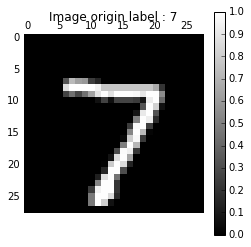

In [20]:
# Origin test data
plt.matshow(img[0,:,:,0], cmap=plt.get_cmap('gray'))
plt.title("Image origin label : " + str(label))
plt.colorbar()
plt.show()

conv1 shape : (1, 28, 28, 64)


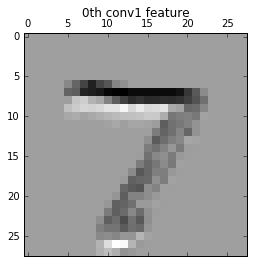

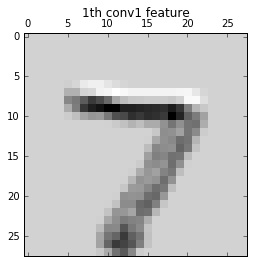

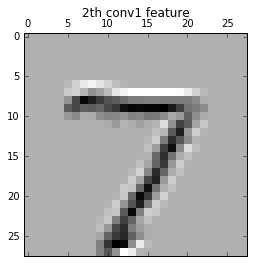

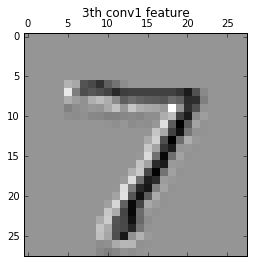

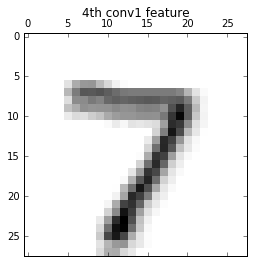

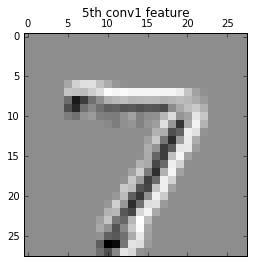

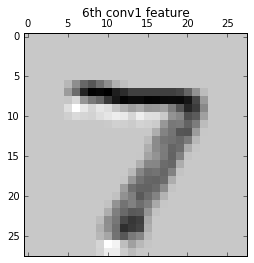

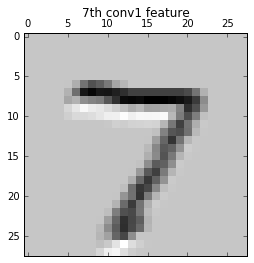

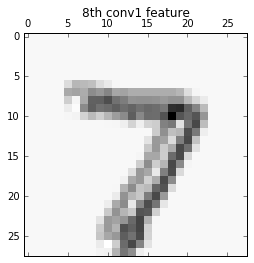

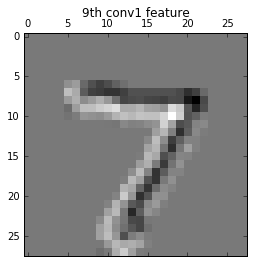

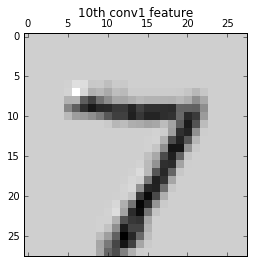

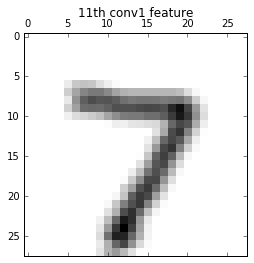

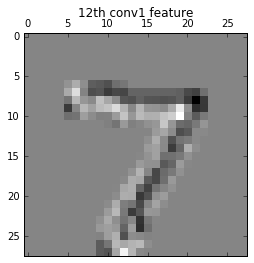

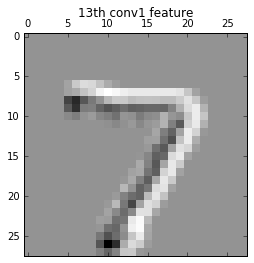

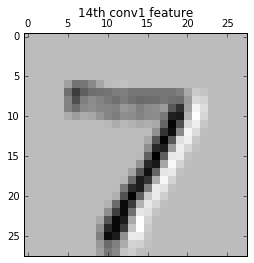

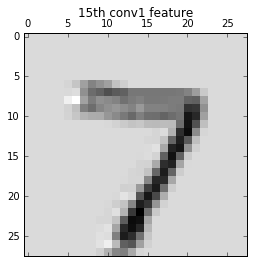

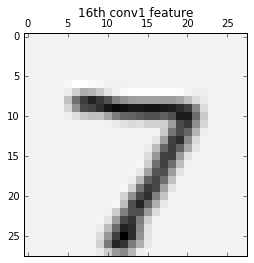

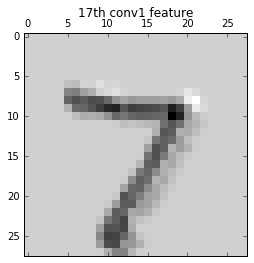

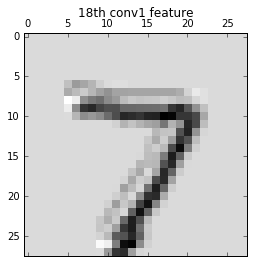

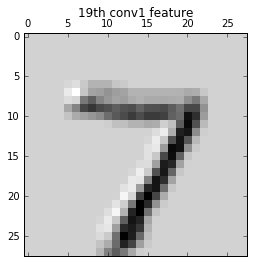

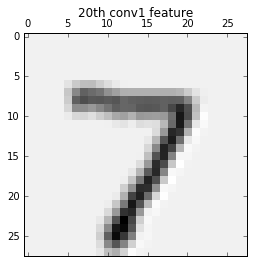

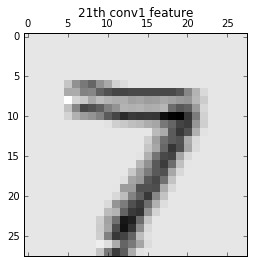

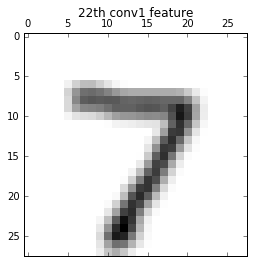

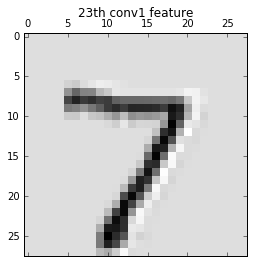

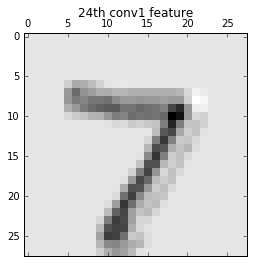

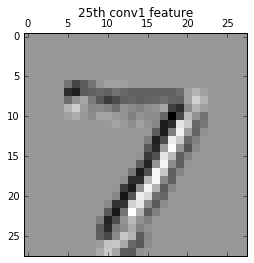

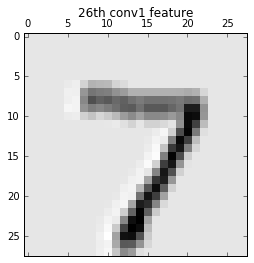

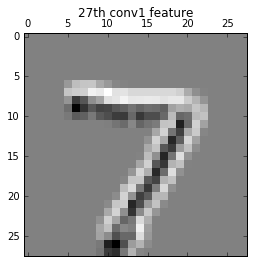

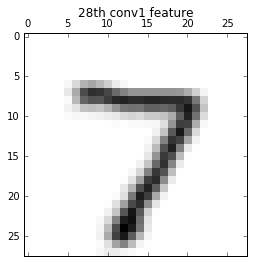

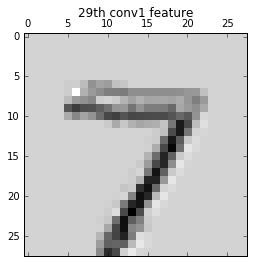

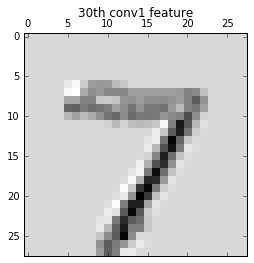

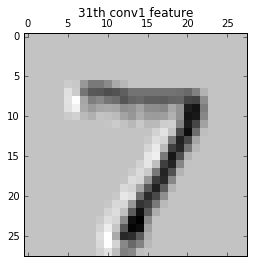

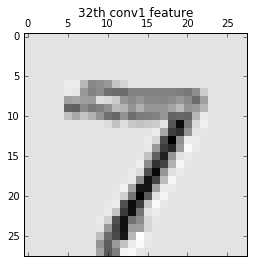

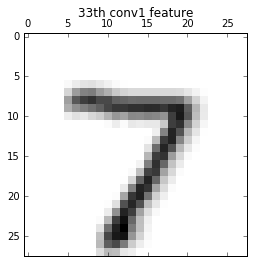

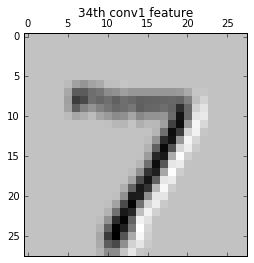

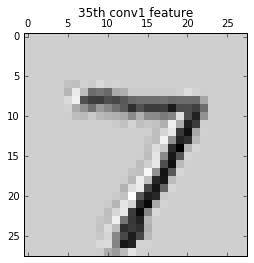

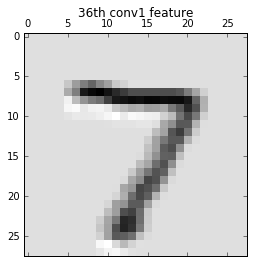

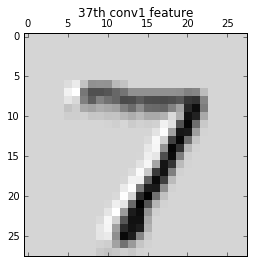

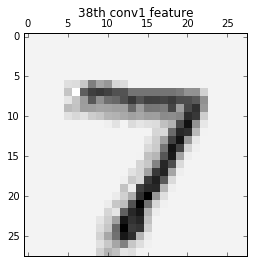

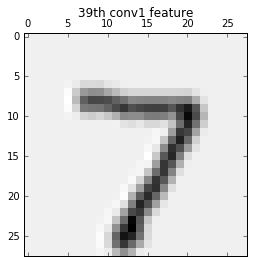

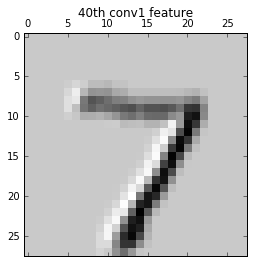

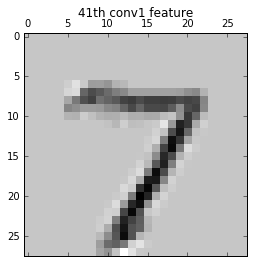

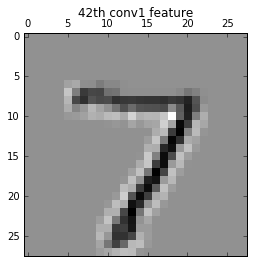

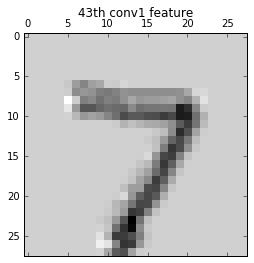

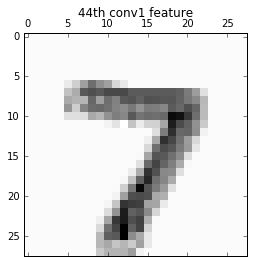

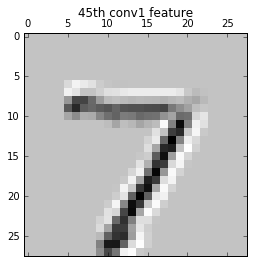

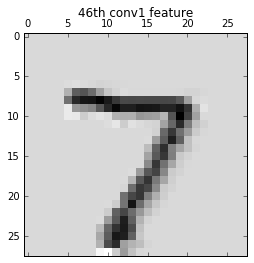

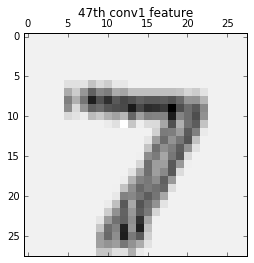

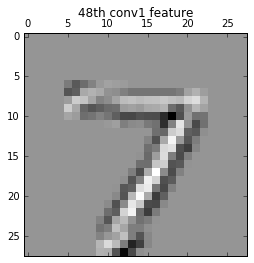

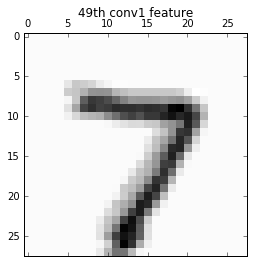

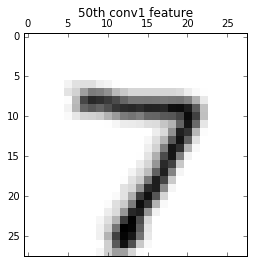

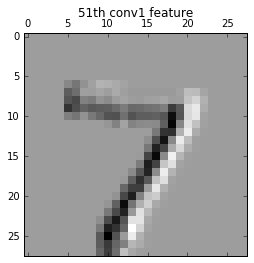

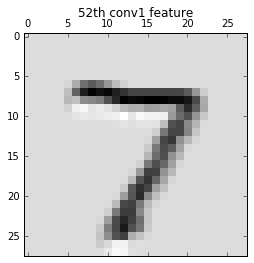

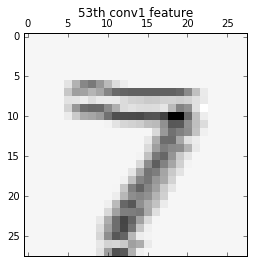

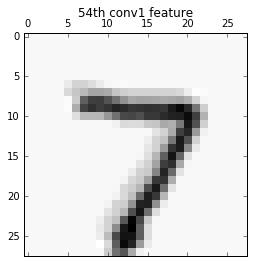

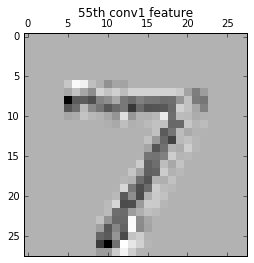

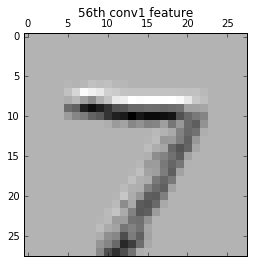

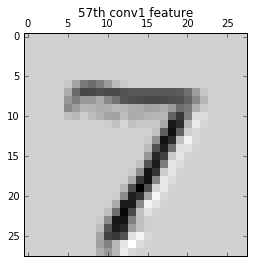

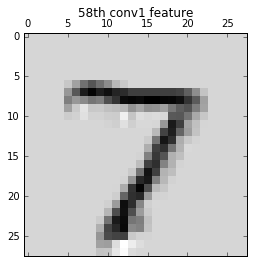

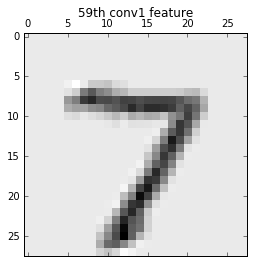

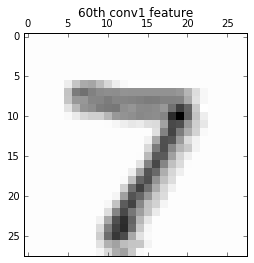

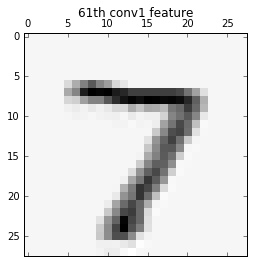

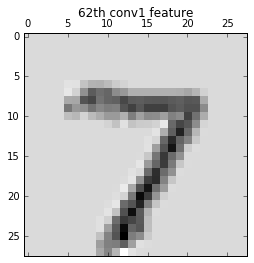

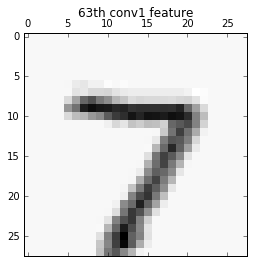

In [26]:
# Convolution feature
print ("conv1 shape : " + str(conv1.shape))
for idx in range(conv1.shape[-1]):
    plt.matshow(conv1[0,:,:,idx], cmap=plt.get_cmap('gray'))
    plt.title(str(idx) + "th conv1 feature")

conv2 shape : (1, 28, 28, 64)


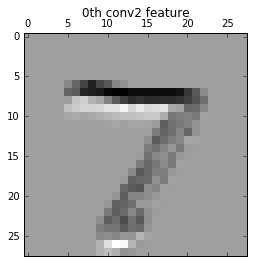

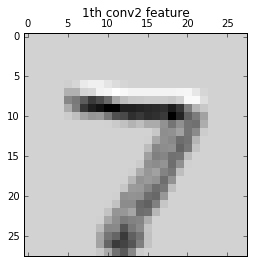

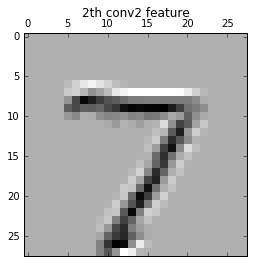

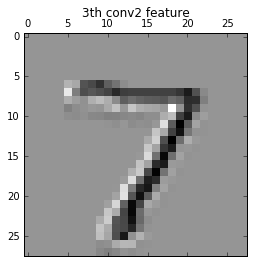

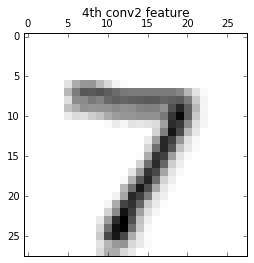

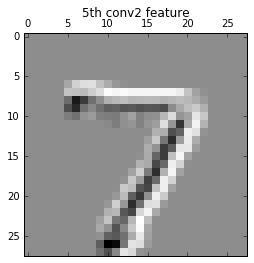

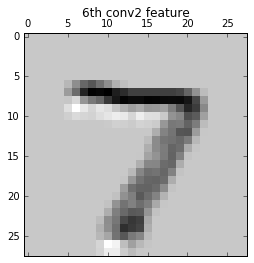

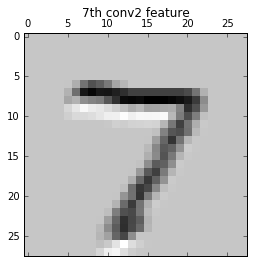

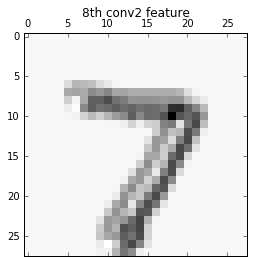

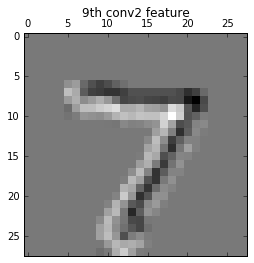

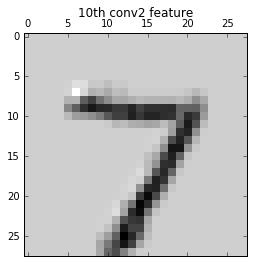

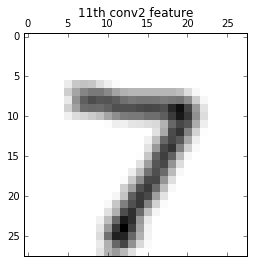

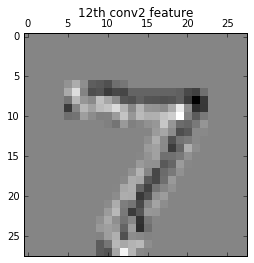

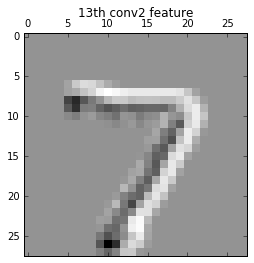

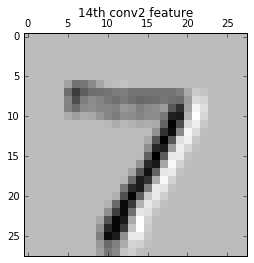

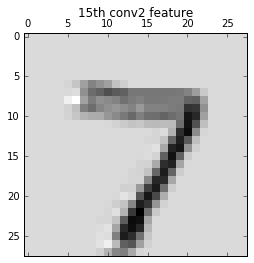

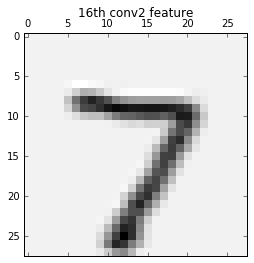

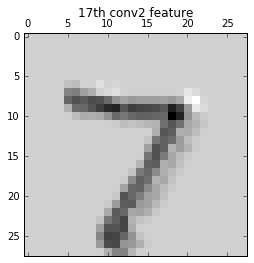

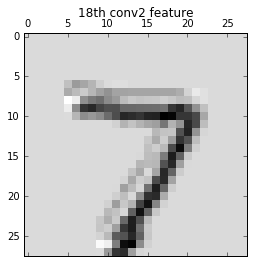

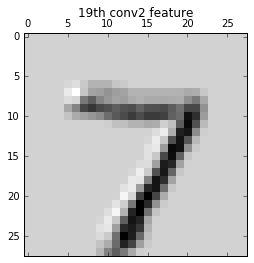

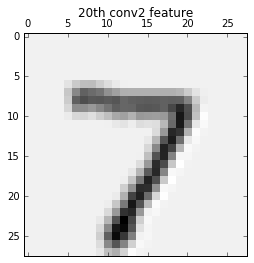

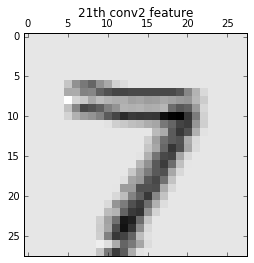

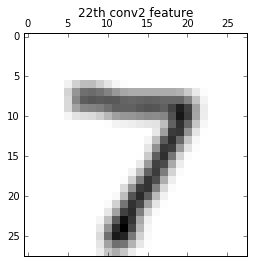

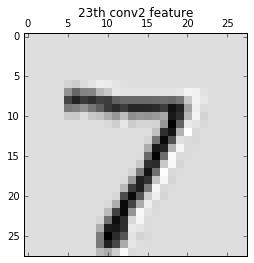

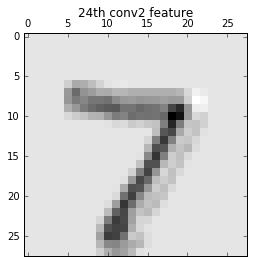

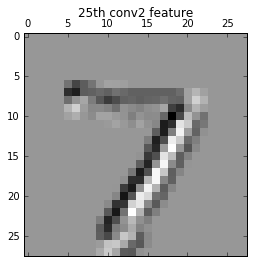

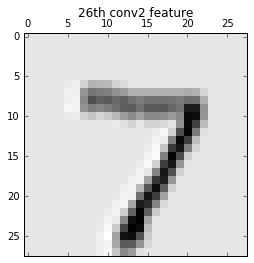

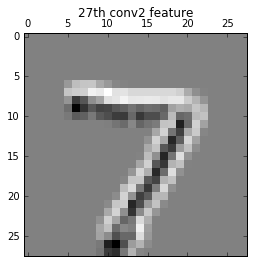

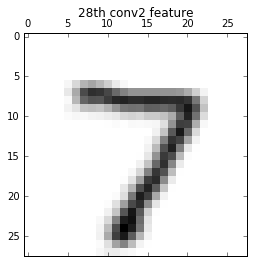

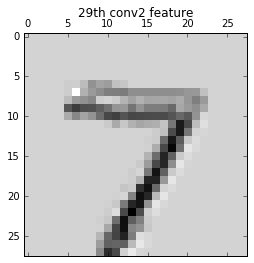

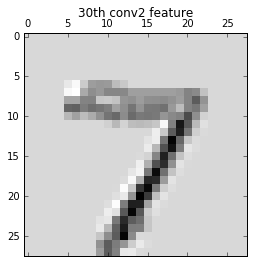

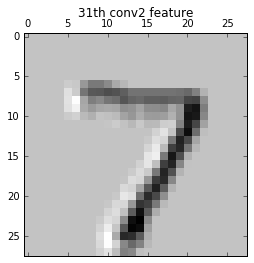

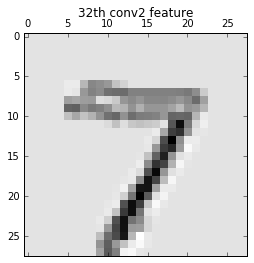

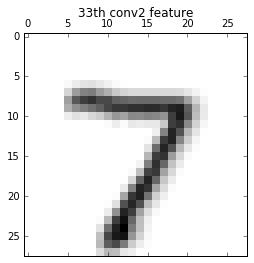

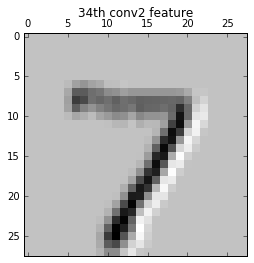

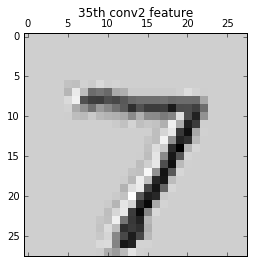

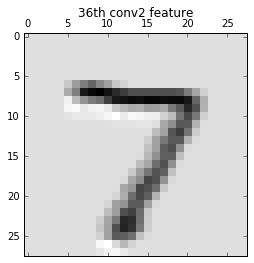

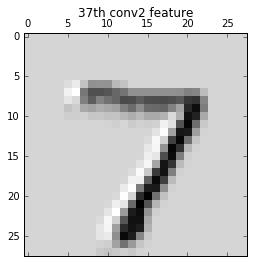

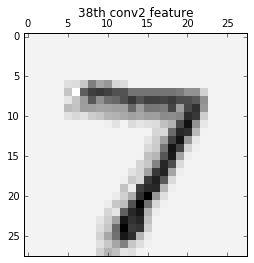

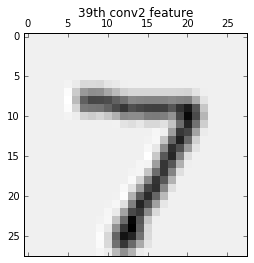

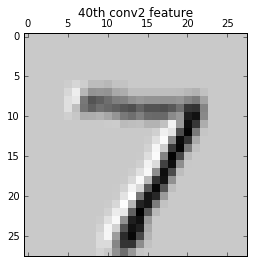

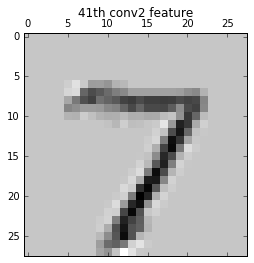

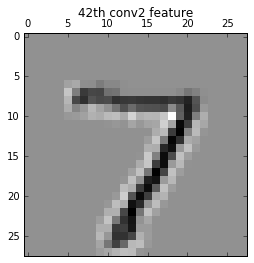

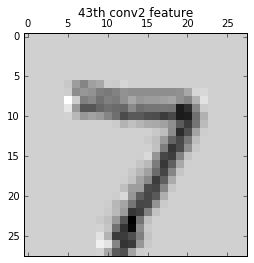

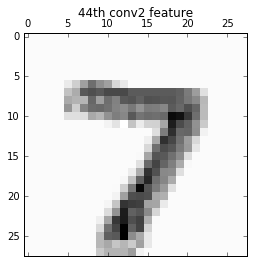

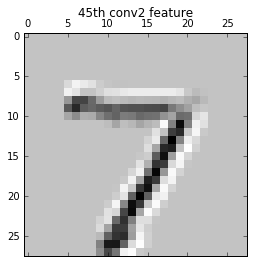

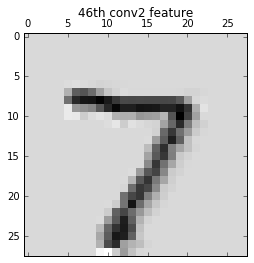

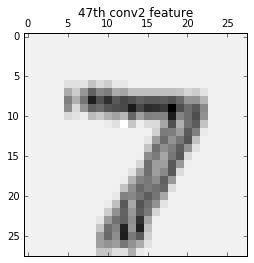

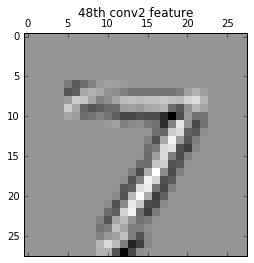

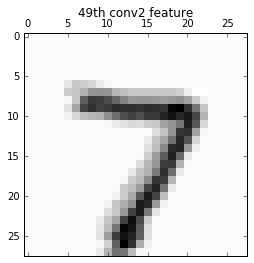

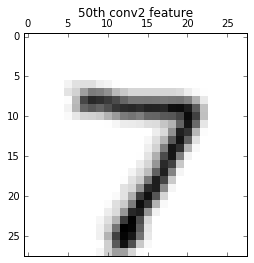

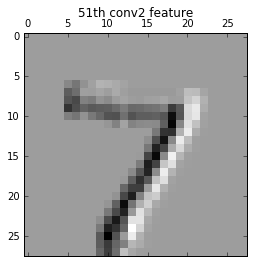

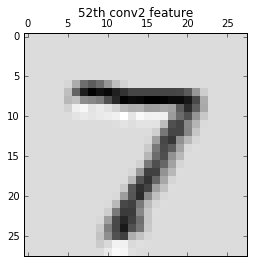

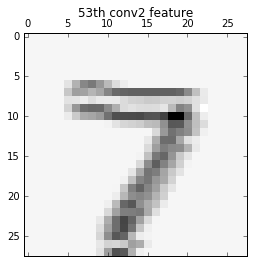

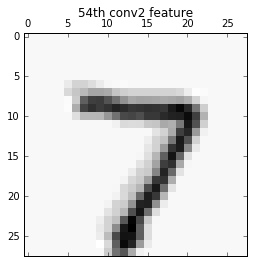

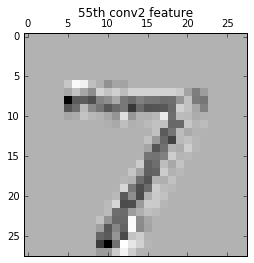

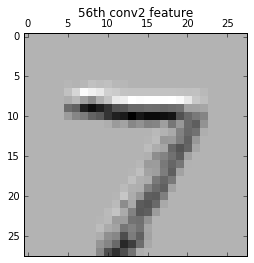

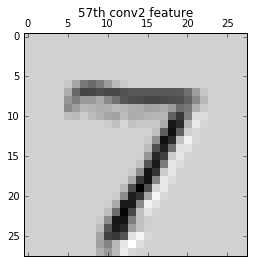

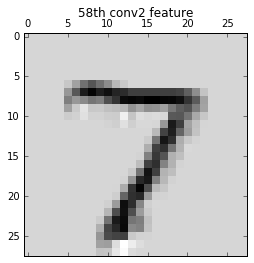

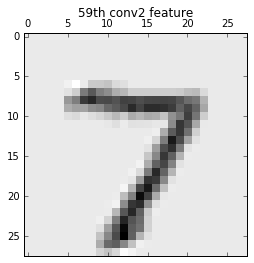

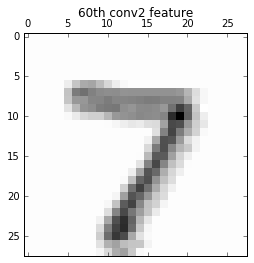

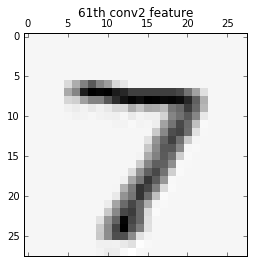

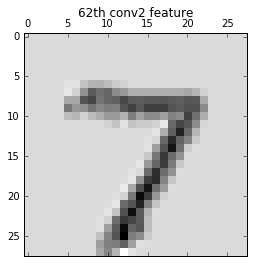

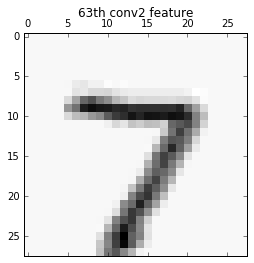

In [31]:
# Convolution feature
print ("conv2 shape : " + str(conv2.shape))
for idx in range(conv2.shape[-1]):
    plt.matshow(conv2[0,:,:,idx], cmap=plt.get_cmap('gray'))
    plt.title(str(idx) + "th conv2 feature")

conv3 shape : (1, 28, 28, 64)


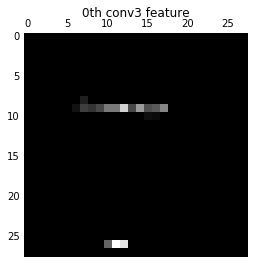

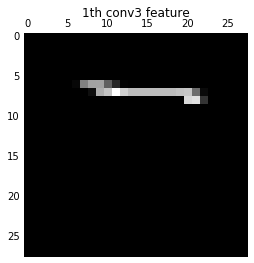

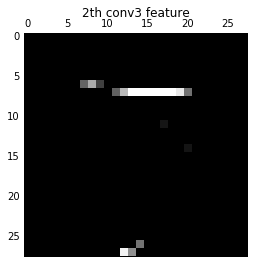

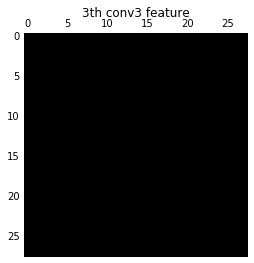

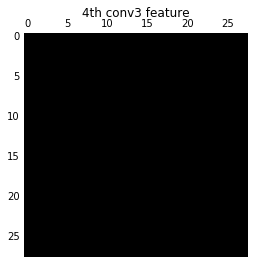

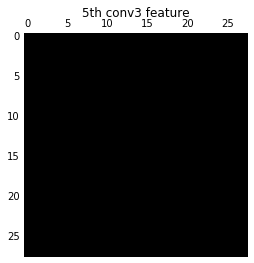

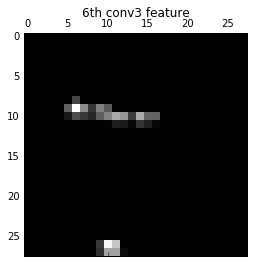

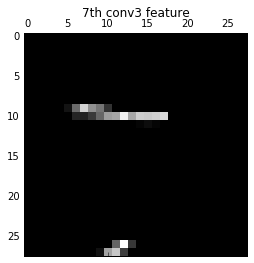

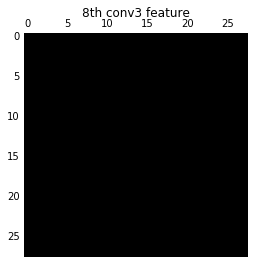

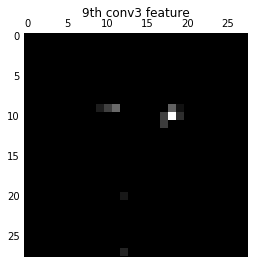

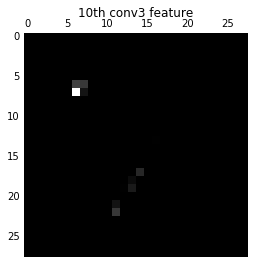

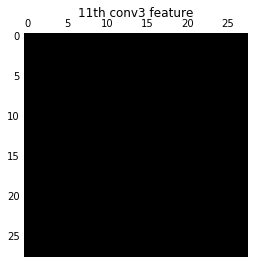

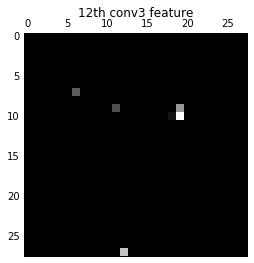

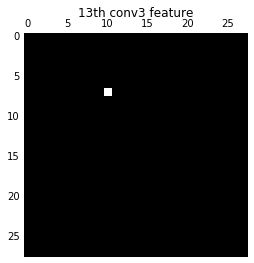

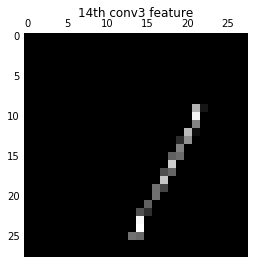

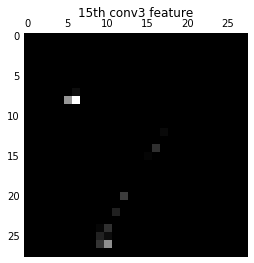

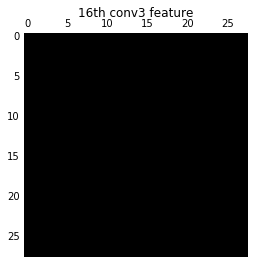

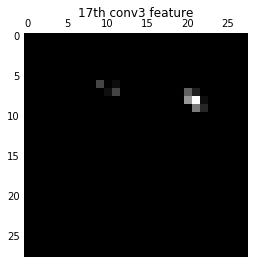

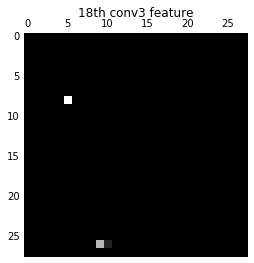

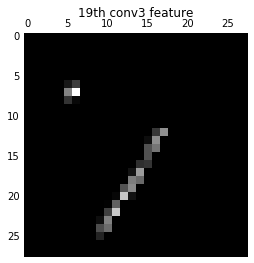

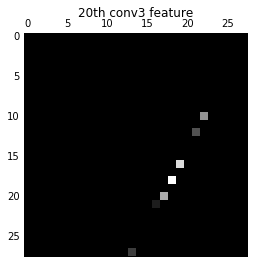

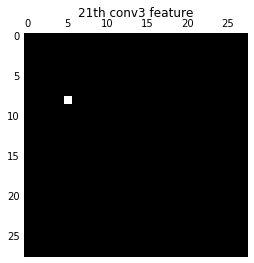

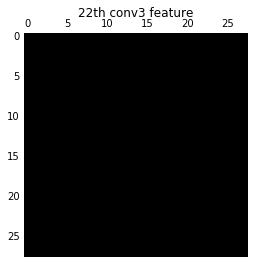

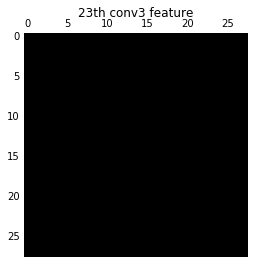

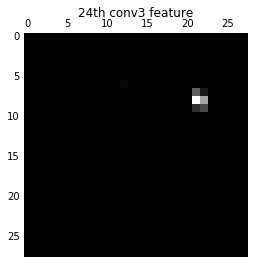

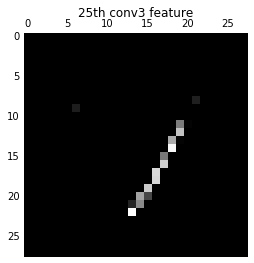

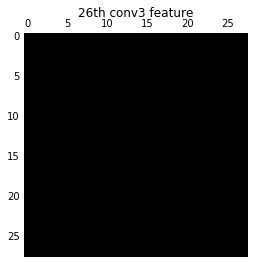

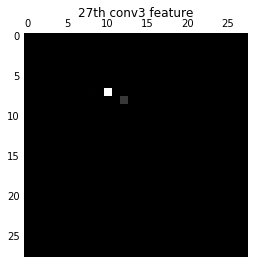

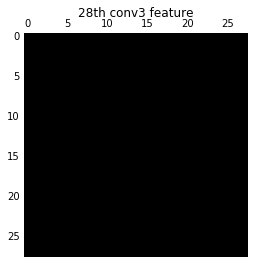

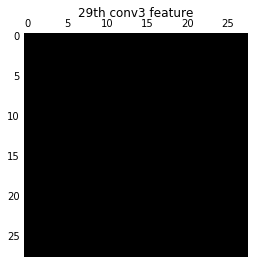

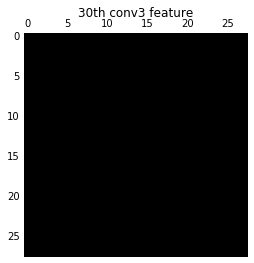

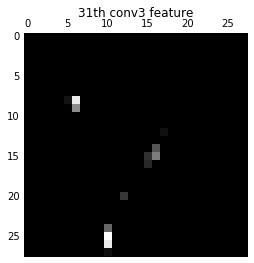

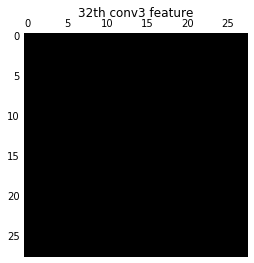

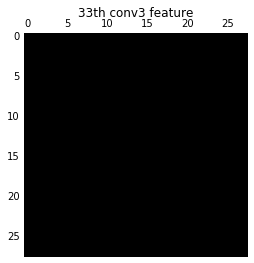

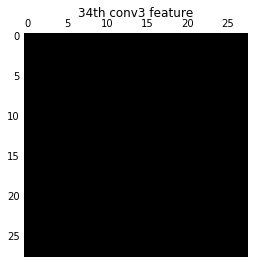

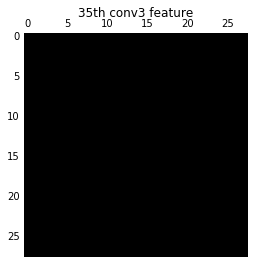

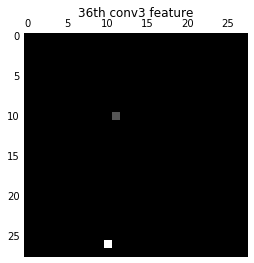

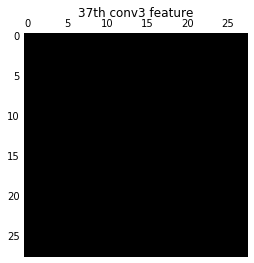

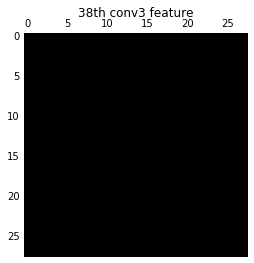

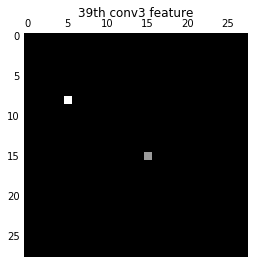

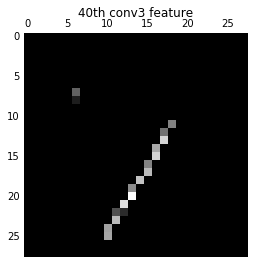

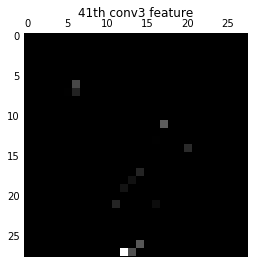

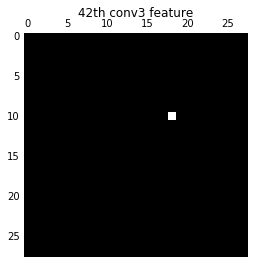

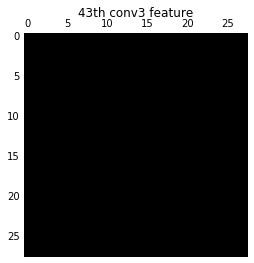

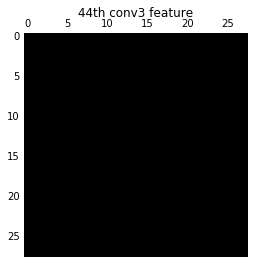

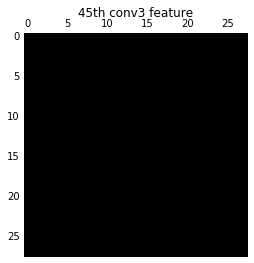

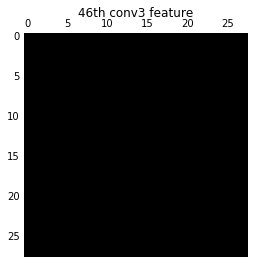

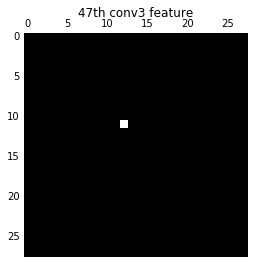

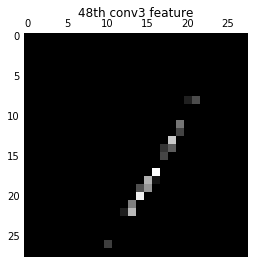

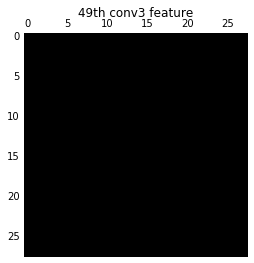

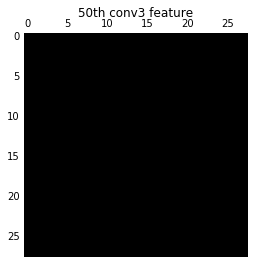

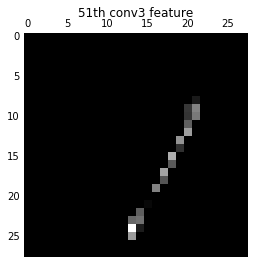

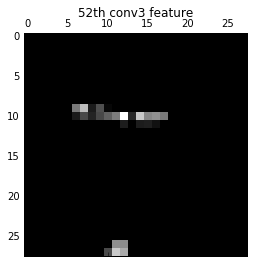

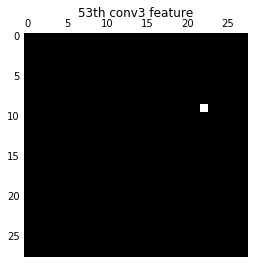

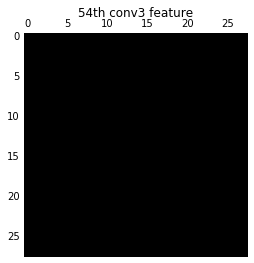

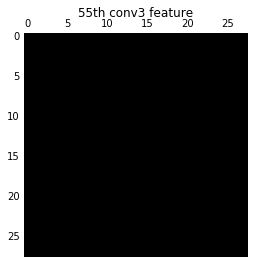

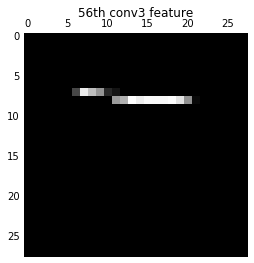

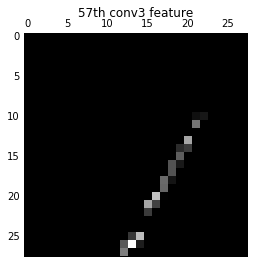

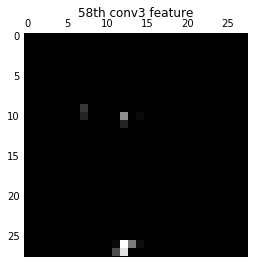

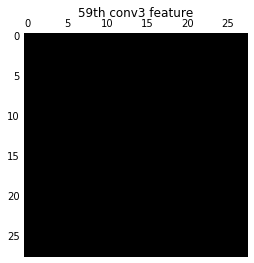

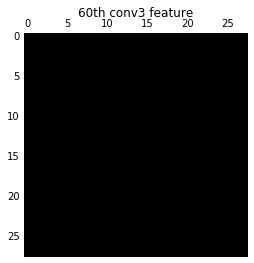

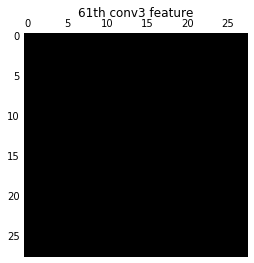

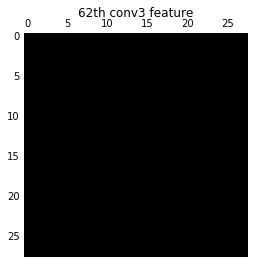

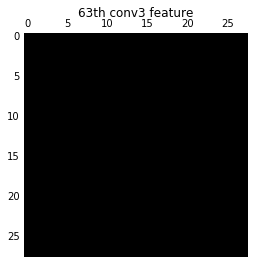

In [32]:
# Convolution feature
print ("conv3 shape : " + str(conv3.shape))
for idx in range(conv3.shape[-1]):
    plt.matshow(conv3[0,:,:,idx], cmap=plt.get_cmap('gray'))
    plt.title(str(idx) + "th conv3 feature")

pool shape : (1, 14, 14, 64)


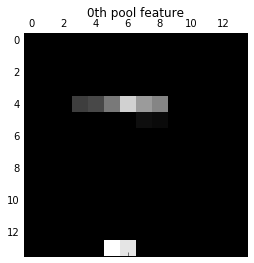

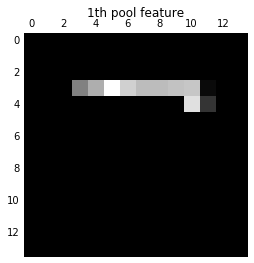

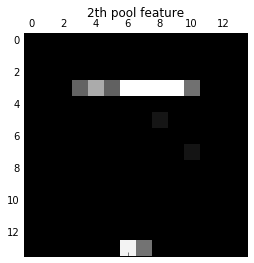

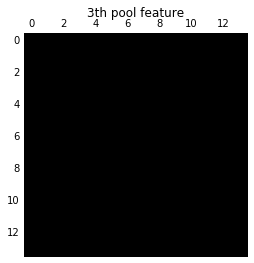

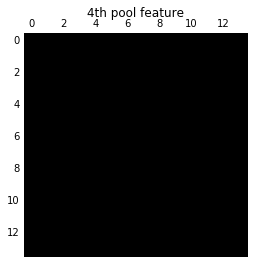

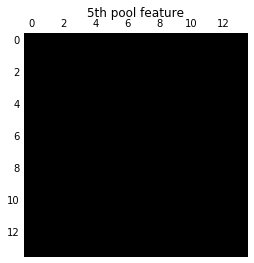

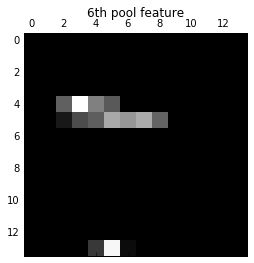

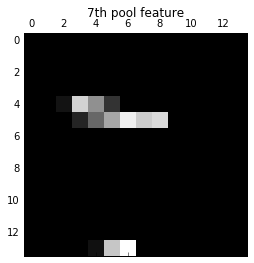

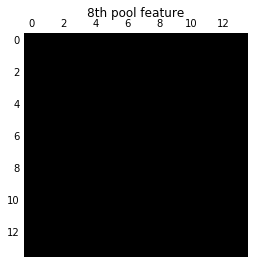

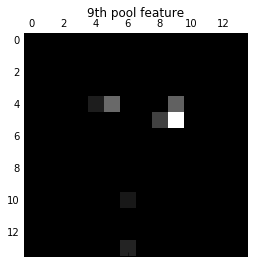

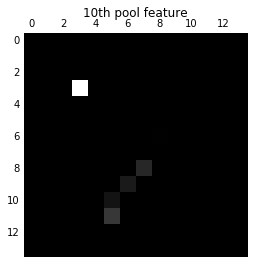

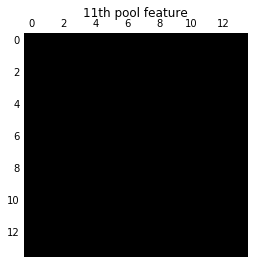

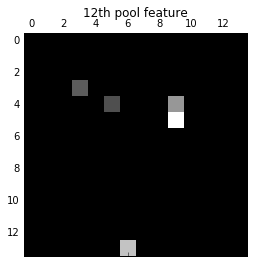

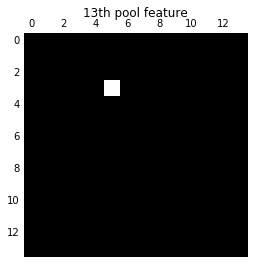

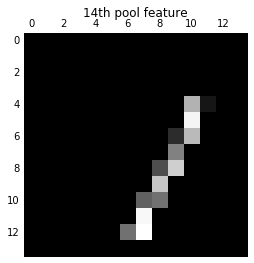

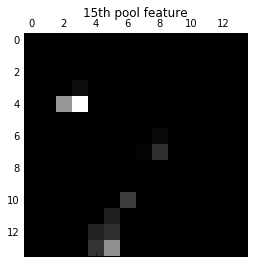

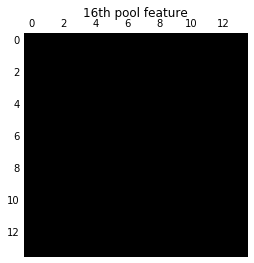

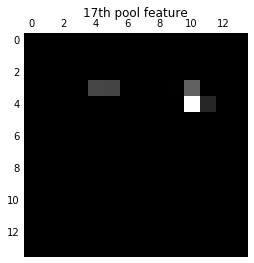

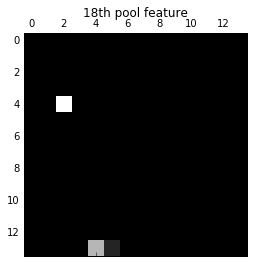

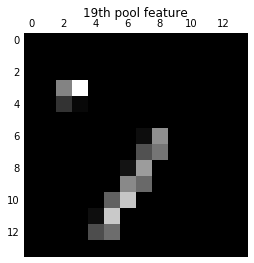

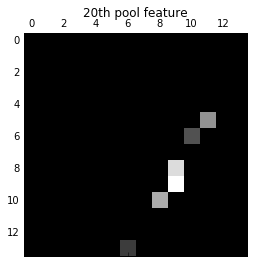

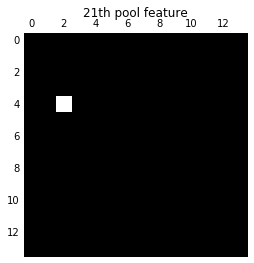

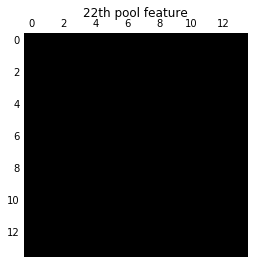

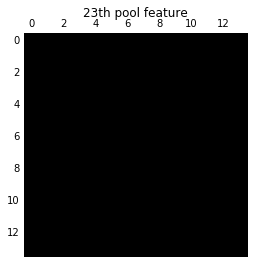

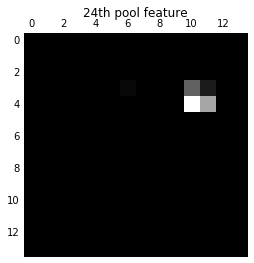

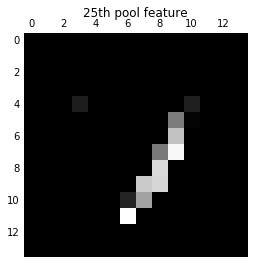

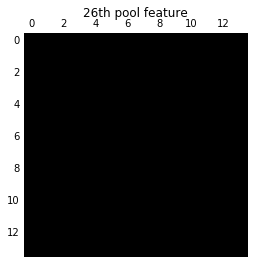

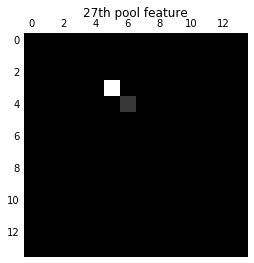

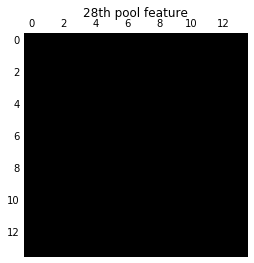

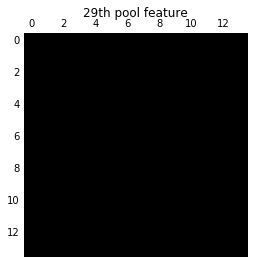

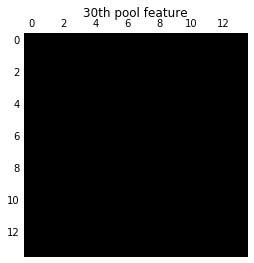

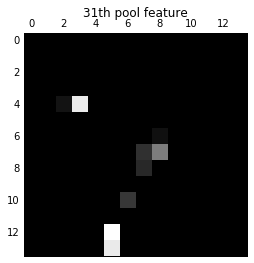

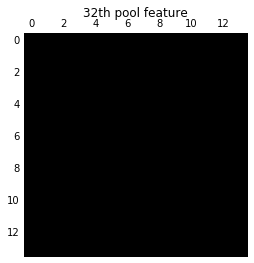

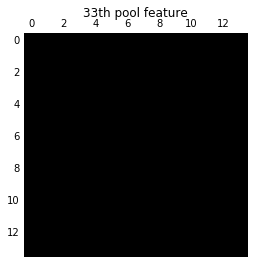

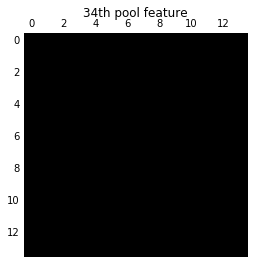

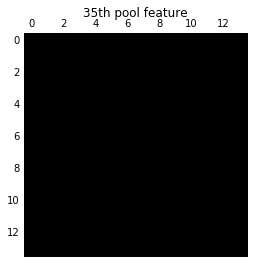

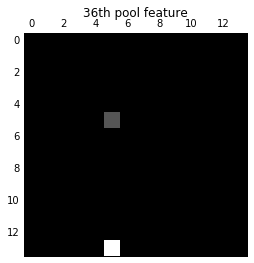

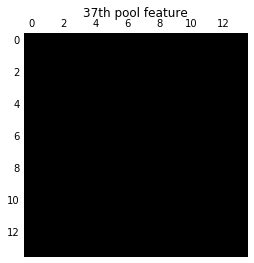

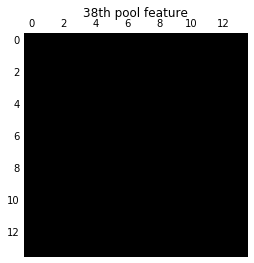

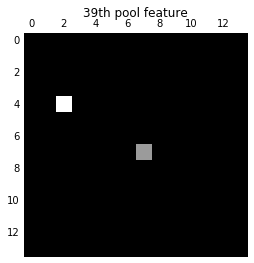

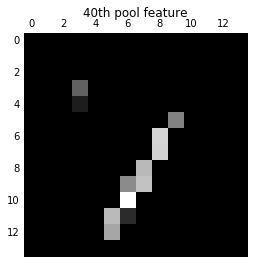

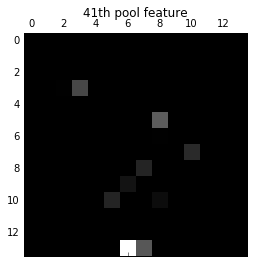

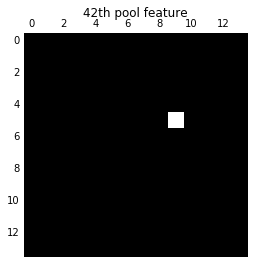

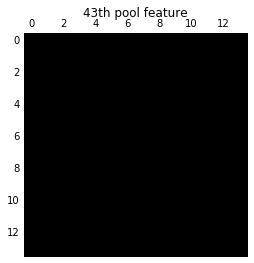

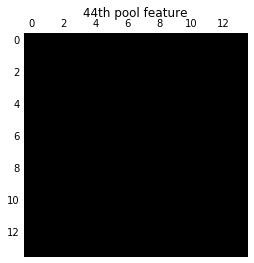

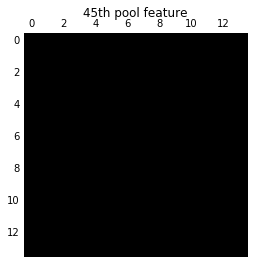

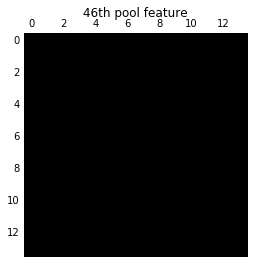

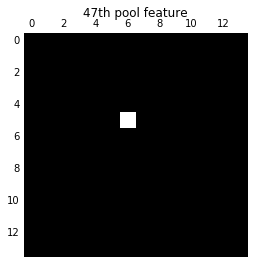

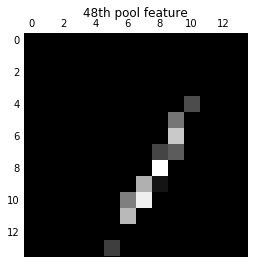

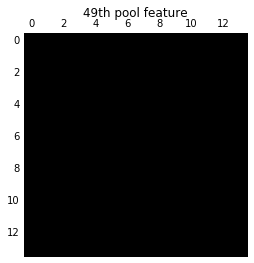

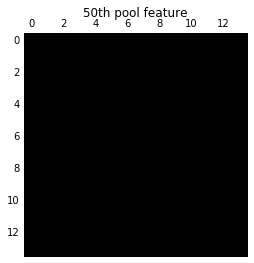

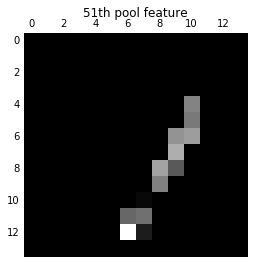

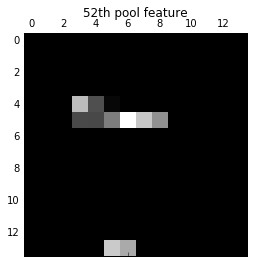

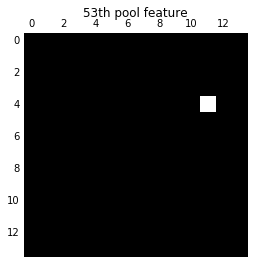

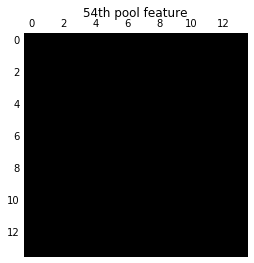

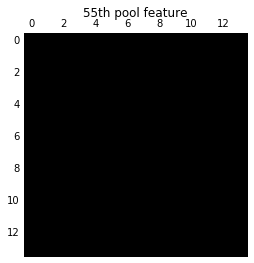

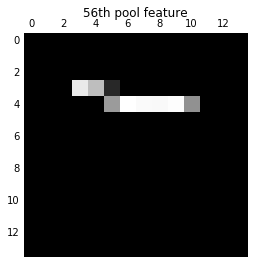

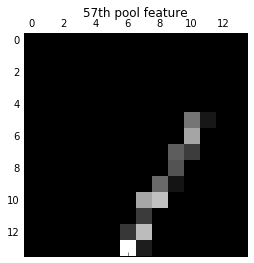

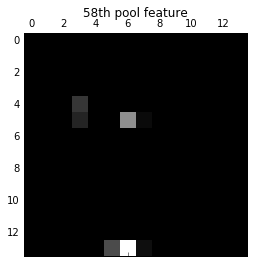

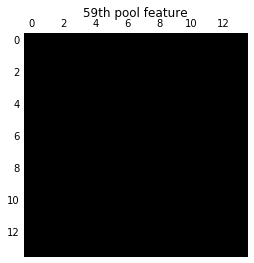

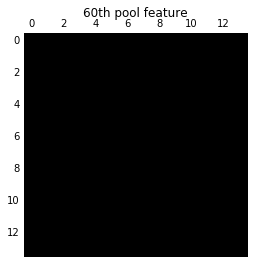

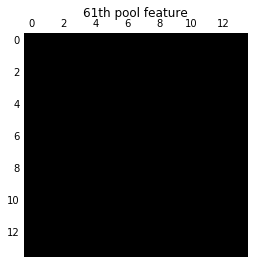

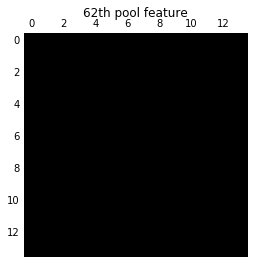

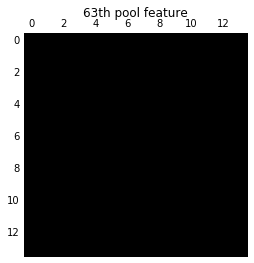

In [33]:
# Convolution feature
print ("pool shape : " + str(pool.shape))
for idx in range(pool.shape[-1]):
    plt.matshow(pool[0,:,:,idx], cmap=plt.get_cmap('gray'))
    plt.title(str(idx) + "th pool feature")

In [37]:
predict_label = np.argmax(sess.run(out, feed_dict={x:tx}))
print ("Predicted label is :" + str(predict_label))

Predicted label is :7
